In [1]:
from guided_backprop import GuidedBackprop
from utils import *
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from keras import backend
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import imageio
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# checkpoint path for trained models
checkpoint_path_model1 = '../../../data/models/20201030_filtered_gaussian/'
#checkpoint_path_model2 = '../../../data/models/20201027_filtered_gaussian_resampled/'

# 0. Model 1: trained on unfiltered data

In [3]:
# build model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(50)(x) 
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

model_1 = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model_1.load_weights(tf.train.latest_checkpoint(checkpoint_path_model1))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model_1.compile(
    loss = 'mse',
    optimizer = adam_optimizer)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f6f65129460> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f6f650e78b0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f6f65219c70> and <tensorflow.python.keras.layers.core.Dropout object at 0x7f6f650f5d60>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f6f650fabe0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f6f6508e610>).


In [4]:
# perform guided backpropagation on model
guided_bprop = GuidedBackprop(model_1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


Visualization of contribution to the prediction for an example image

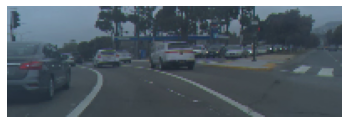

In [5]:
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/234_162run1.png')) 
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/8_786run1.png')) 
img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/3/137_707run1.png')) 
img = cv2.resize(img_orig, (291, 218))[76:142, 45:245,0:3]/255
# original image
plt.imshow(img)
plt.axis('off')
#plt.savefig('images/unfiltered_gaussian_resampled_img3.png', bbox_inches='tight')

## Model 1: Guided Backprop

a. mask only

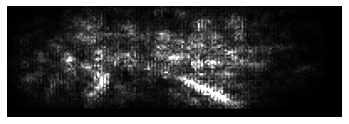

In [6]:
# get mask for the guided bprop
mask = guided_bprop.get_mask(img)  
# increase pixel value for better visibility
#mask = mask*20
# show only green pixels
#mask[:, :,[0,2]] = 0
show_image(mask)  
#plt.savefig('images/unfiltered_gaussian_resampled_guided_backprop_img3.png', bbox_inches='tight')

b. mask on top of the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 199.5, 65.5, -0.5)

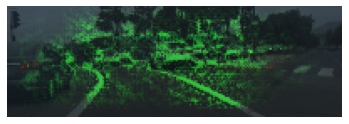

In [7]:
fig,ax = plt.subplots(1)
ax.imshow(img, cmap='jet')
for i in range(0,mask.shape[0]):
    for j in range(0,mask.shape[1]):
        mask[i, j, 1] = max(mask[i, j, 0], mask[i, j, 1], mask[i, j, 2])
mask[:,:,[0,2]] = 0
ax.imshow(mask*20, alpha = 0.5, cmap = 'Greens')
plt.axis('off')
#plt.savefig('images/unfiltered_gaussian_resampled_guided_backprop_layered_img1.png')

## Model 1: Vanilla Gradient

In [ ]:
from saliency import GradientSaliency
vanilla = GradientSaliency(model_1)

In [8]:
mask = vanilla.get_mask(img)
show_image(mask)
#plt.savefig('images/unfiltered_gaussian_resampled_vanilla_gradient.png')

NameError: name 'vanilla' is not defined

## Model 1: Smoothed Guided Backprop

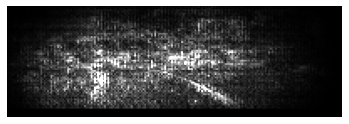

In [9]:
from integrated_gradients import IntegratedGradients
x = np.expand_dims(img, axis=0)
mask = guided_bprop.get_smoothed_mask(x[0])
show_image(mask)
#plt.savefig('images/unfiltered_gaussian_resampled_smoothed_guided_backprop_img2.png', bbox_inches='tight')

In [ ]:
## Model 1: Integrated Grad

In [10]:
from integrated_gradients import IntegratedGradients
inter_grad = IntegratedGradients(model_1)
mask = inter_grad.get_mask(x[0])
#show_image(mask, title='integrated grad')

## Model 1: Guided Backprop with full image

In [ ]:
img_large = cv2.resize(img_orig, (291, 218))
mask_large = np.zeros((218, 291,3))
mask_large[76:142, 45:245,0:3] = mask*20
mask_large_mod = mask_large.copy()
for i in range(0,mask_large_mod.shape[0]):
    for j in range(0,mask_large_mod.shape[1]):
        mask_large_mod[i, j, 1] = max(mask_large_mod[i, j, 0], mask_large_mod[i, j, 1], mask_large_mod[i, j, 2])
mask_large_mod[:,:,[0,2]] = 0
fig,ax = plt.subplots(1)
ax.imshow(img_large/255)
rect = patches.Rectangle((45,76),200,66, linewidth=1,edgecolor='grey',facecolor='none')
ax.imshow(mask_large_mod, alpha = 0.5, cmap = 'Greens')
ax.add_patch(rect)
plt.axis('off') 
fig.savefig('images/unfiltered_gaussian_large_view_img1.png')

## Model 2: trained on cleaned data

In [ ]:
# build model
Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
x = BatchNormalization()(x)
x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1164)(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(50)(x) 
x = Dense(10)(x)
Output = Dense(1, name = 'output_layer')(x)

model_2 = tf.keras.models.Model(
      inputs = [Input], outputs = [Output])

def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

model_2.load_weights(tf.train.latest_checkpoint(checkpoint_path_model2))

adam_optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model_2.compile(
    loss = 'mse',
    optimizer = adam_optimizer)

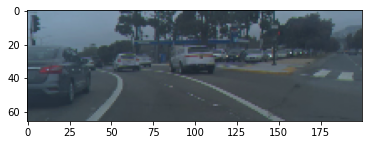

In [8]:
# other good images:
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/234_162run1.png')) 
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/8_786run1.png')) 
img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/3/137_707run1.png')) 
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/8_786run1.png')) 
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/149_912run1.png')) 
# image of standing car:
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/28_911run1.png')) 
#img_orig = imageio.imread(str('../../../data/commaai/train_bags_2/0/80_436run1.png')) 
img = cv2.resize(img_orig, (291, 218))[76:142, 45:245,0:3]/255
# original image
plt.imshow(img)

In [ ]:
## Model 2: Guided Backprop

In [ ]:
guided_bprop = GuidedBackprop(model_2)

In [ ]:
# get mask for the guided bprop
mask = guided_bprop.get_mask(img)  
# increase pixel value for better visibility
mask = mask
show_image(mask)  
# show only green pixels
plt.savefig('images/filtered_gaussian_resampled_guided_backprop_img3.png', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(img, cmap='jet')
for i in range(0,mask.shape[0]):
    for j in range(0,mask.shape[1]):
        mask[i, j, 1] = max(mask[i, j, 0], mask[i, j, 1], mask[i, j, 2])
mask[:,:,[0,2]] = 0
ax.imshow(mask*5, alpha = 0.5, cmap = 'Greens')
plt.axis('off')
plt.savefig('images/filtered_gaussian_resampled_guided_backprop_layered_img1.png', , bbox_inches='tight')

In [ ]:
img_large = cv2.resize(img_orig, (291, 218))
mask_large = np.zeros((218, 291,3))
mask_large[76:142, 45:245,0:3] = mask*10
mask_large_mod = mask_large.copy()
for i in range(0,mask_large_mod.shape[0]):
    for j in range(0,mask_large_mod.shape[1]):
        mask_large_mod[i, j, 1] = max(mask_large_mod[i, j, 0], mask_large_mod[i, j, 1], mask_large_mod[i, j, 2])
mask_large_mod[:,:,[0,2]] = 0
fig,ax = plt.subplots(1)
ax.imshow(img_large/255)
rect = patches.Rectangle((45,76),200,66, linewidth=1,edgecolor='grey',facecolor='none')
ax.imshow(mask_large_mod, alpha = 0.5, cmap = 'Greens')
ax.add_patch(rect)
plt.axis('off') 
fig.savefig('images/filtered_gaussian_large_view_img3.png')